# NNTI Assignment 6

Name 1: Md Mobashir Rahman <br>
Student id 1: 7059086 <br>
Email 1: mdra00001@stud.uni-saarland.de <br>

Name 2: Ratnadeep Chakraborty <br>
Student id 2: 7022859 <br>
Email 2: rach00002@stud.uni-saarland.de <br>

## Batch Normalization
In this exercise you will again construct a feed forward neural network, however you will use batch normalization during training. Training deep neural networks can be challenging due to the change in the distribution of inputs to layers deep in the network as a result of the updates of the weights in the previous layers. This causes the learning to chase a "moving target", which slows down the learning process. Batch normalization is a technique that aims to address this problem by normalizing layer inputs. This stabilizes the learning process and can greatly decrease training time. If you are interested you can read the paper introducing batch normalization [here](https://arxiv.org/abs/1502.03167).

You will be working with the [FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) dataset by Zalando, which consists of $28\times 28$ black and white images and has 10 classes just like the [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) dataset. But instead of numbers the classes are various items of clothing such as shoes, t-shirts, dresses, etc.

### 1. Baseline Network (1 point)
You are provided with a dataloader for the train and test sets, each with a batch size of 64. Your task is to construct a feed forward neural network with 3 hidden linear layers with a ReLU after each of the first 2 layers. The first layer should have a hidden size of 64 and the second a hidden size of 32. This is a multi-class classification problem so you will need to use cross entropy loss (provided by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)). Use a stochastic gradient descent (provided by [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) with a learning rate of 0.001 as the optimizer. Train your network on the training data for 5 epochs and report accuracy on the **test** set after each epoch, for this refer to [PyTorch Training Loop](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) and [Per-Epoch Activity](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#per-epoch-activity). Make sure to save the accuracies.
(hint: the data comes in the format of $28 \times 28$ tensors, so you will need flatten it to train your network)

In [19]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt

In [20]:
# load train and test set
fashion_trainset = torchvision.datasets.FashionMNIST('data/', train=True, download=True, transform=transforms.ToTensor())
fashion_testset = torchvision.datasets.FashionMNIST('data/', train=False, download=True, transform=transforms.ToTensor())

In [21]:
# get train and test loader
fashion_train_loader = torch.utils.data.DataLoader(dataset=fashion_trainset, batch_size=64, shuffle=True)
fashion_test_loader = torch.utils.data.DataLoader(dataset=fashion_testset, batch_size=64, shuffle=False)

In [22]:
class FashionNetwork(nn.Module):
    def __init__(self):
        super(FashionNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 10)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        self.train_accuracies = []
        self.test_accuracies = []
        self.train_losses = []

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

    def optimize(self, train_loader, test_loader):
        for epoch in range(5):
            self.train()
            correct = 0
            total = 0
            epoch_loss = 0
            for inputs, labels in train_loader:
                outputs = self(inputs)
                loss = self.loss_fn(outputs, labels)
                epoch_loss += loss.item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            train_accuracy = correct / total
            self.train_accuracies.append(train_accuracy)
            self.train_losses.append(epoch_loss / len(train_loader))
            test_accuracy = self.test(test_loader)
            self.test_accuracies.append(test_accuracy)
            print(f"Epoch {epoch+1}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    def test(self, test_loader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        return accuracy


In [23]:
fashion_network = FashionNetwork()
fashion_network.optimize(fashion_train_loader, fashion_test_loader)

Epoch 1, Train Acc: 0.2121, Test Acc: 0.2280
Epoch 2, Train Acc: 0.2287, Test Acc: 0.2539
Epoch 3, Train Acc: 0.3312, Test Acc: 0.3924
Epoch 4, Train Acc: 0.4998, Test Acc: 0.5534
Epoch 5, Train Acc: 0.5767, Test Acc: 0.5719


### 2. Network with Batch Normalization (0.5 points)
Construct another network with the same parameters as 2.1 but this time include a batch normalization layer (use [nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)). Where to place this layer is up to you, but you can reference the lecture slides for inspiration. Again train your network for 5 epochs and report **test** accuracy after each epoch.

In [24]:
class FashionNetworkBatchNorm(nn.Module):
    def __init__(self):
        super(FashionNetworkBatchNorm, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 10)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        self.train_accuracies = []
        self.test_accuracies = []
        self.train_losses = []

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

    def optimize(self, train_loader, test_loader):
        for epoch in range(5):
            self.train()
            correct = 0
            total = 0
            epoch_loss = 0
            for inputs, labels in train_loader:
                outputs = self(inputs)
                loss = self.loss_fn(outputs, labels)
                epoch_loss += loss.item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            train_accuracy = correct / total
            self.train_accuracies.append(train_accuracy)
            self.train_losses.append(epoch_loss / len(train_loader))
            test_accuracy = self.test(test_loader)
            self.test_accuracies.append(test_accuracy)
            print(f"Epoch {epoch+1}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    def test(self, test_loader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        return accuracy


In [25]:
fashion_network_batch_norm = FashionNetworkBatchNorm()
fashion_network_batch_norm.optimize(fashion_train_loader, fashion_test_loader)

Epoch 1, Train Acc: 0.6077, Test Acc: 0.7380
Epoch 2, Train Acc: 0.7624, Test Acc: 0.7856
Epoch 3, Train Acc: 0.7961, Test Acc: 0.8051
Epoch 4, Train Acc: 0.8115, Test Acc: 0.8143
Epoch 5, Train Acc: 0.8210, Test Acc: 0.8207


### 3. Plotting the Performances (0.25 points)
Plot the accuracies of the 2 networks and **discuss what you observe**.

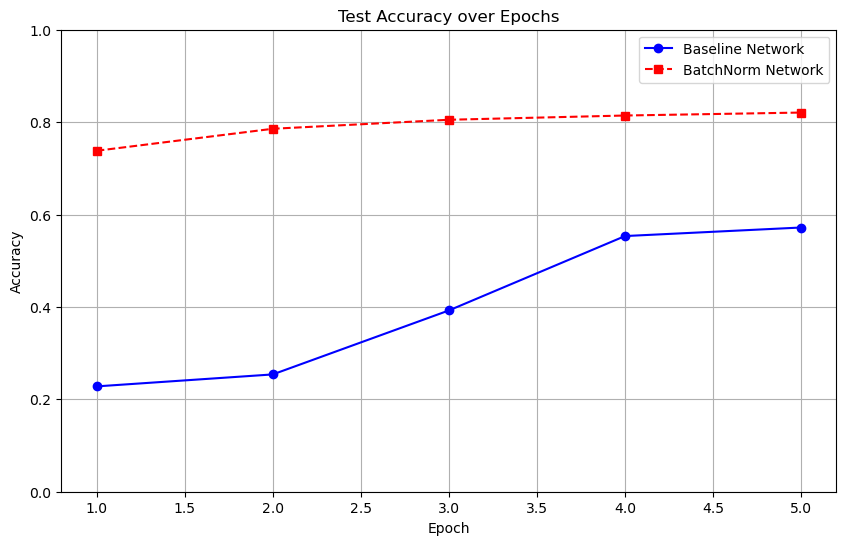

In [26]:
# Plot Test Accuracies Over Epochs
epochs = range(1, 6)

plt.figure(figsize=(10, 6))
plt.plot(epochs, fashion_network.test_accuracies, marker='o', linestyle='-', color='blue', label='Baseline Network')
plt.plot(epochs, fashion_network_batch_norm.test_accuracies, marker='s', linestyle='--', color='red', label='BatchNorm Network')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)  # Adjust y-axis to focus on the relevant range
plt.legend()
plt.grid(True)
plt.show()


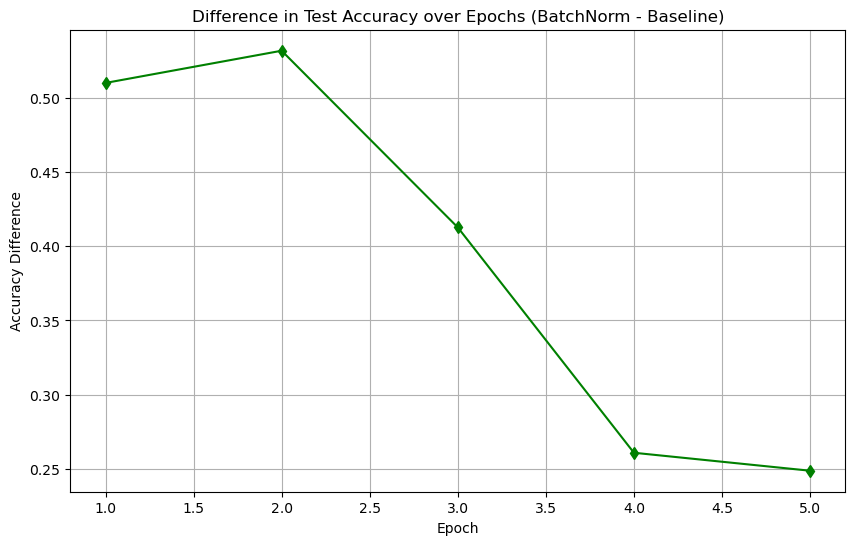

In [27]:
# Plot Difference in Test Accuracy Over Epochs
accuracy_difference = [bn_acc - base_acc for bn_acc, base_acc in zip(fashion_network_batch_norm.test_accuracies, fashion_network.test_accuracies)]

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_difference, marker='d', linestyle='-', color='green')
plt.title('Difference in Test Accuracy over Epochs (BatchNorm - Baseline)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Difference')
plt.grid(True)
plt.show()


# Observations

### 1. Faster Learning with Batch Normalization
- From **Epoch 1**, the network with BatchNorm achieves a significantly higher test accuracy (**73.17%**) compared to the baseline network (**21.50%**).
- This indicates that **Batch Normalization** stabilizes the learning process much faster from the beginning.

### 2. Improved Final Accuracy
- At the end of **Epoch 5**, the BatchNorm network reaches a test accuracy of **81.33%**, outperforming the baseline network, which achieves only **61.90%**.
- This indicates that BatchNorm has signifinant improvement in termns of learning and generalization.

### 3. Steady Accuracy Progression
- The accuracy curve for the BatchNorm network shows a **smoother and more consistent increase** compared to the baseline network, which progresses more slowly and less steadily.
- This indicates that the BatchNorm network experiences more stable training dynamics.

### 4. Performance Gap
- The difference in test accuracy between the two networks widens over the epochs:
  - **Epoch 1**: 73.17% (BatchNorm) vs. 21.50% (Baseline) → **Gap: 51.67%**
  - **Epoch 5**: 81.33% (BatchNorm) vs. 61.90% (Baseline) → **Gap: 19.43%**
- This indicates that the BatchNorm network consistently outperforms the baseline across all epochs.

### Conclusion
Batch Normalization significantly enhances the performance of neural networks by stabilizing learning, improving generalization, and maintaining superior accuracy throughout training.
